In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import sklearn
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
# Task 0 remove document identifier and topic label then...

def read_documents(doc_file):
    docs = []
    labels = []
    with open(doc_file) as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            labels.append(words[1])
    return docs, labels

In [3]:
all_docs, all_labels = read_documents('dataset.txt')

# 80% of data will be used for training; remaining 20% for testing
split_point = int(0.80 * len(all_docs))
train_docs = all_docs[:split_point]
train_labels = all_labels[:split_point]
eval_docs = all_docs[split_point:]
eval_labels = all_labels[split_point:]

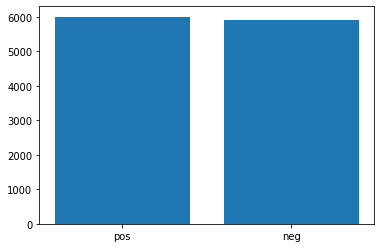

In [4]:
# Task 1 Plot the distribution of the number of the instances in each class.
distribution = np.array([[label, all_labels.count(label)] for label in set(all_labels)])

plt.bar(distribution[:, 0], distribution[:, 1].astype(int))
plt.xlabel = "reviews"
plt.ylabel = "count"

In [5]:
# convert to frequency count matrix.
train_strings = [' '.join(doc) for doc in train_docs]
eval_strings = [' '.join(doc) for doc in eval_docs]
# convert training set strings to feature matrix using CountVectorizer
cv = CountVectorizer(token_pattern = r"\S+") # a word is any sequence of non-whitespace characters
cv_train = cv.fit_transform(train_strings)
train_feat = cv_train.toarray()
# only transform and not fit for eval_strings, since want to keep same vocabulary as training
cv_eval = cv.transform(eval_strings)
eval_feat = cv_eval.toarray()

In [6]:
# Task 2: Run 3 different ML models:
# a) Naive Bayes Classifier
nb = sklearn.naive_bayes.MultinomialNB(alpha = 0.5)
nb.fit(train_feat, train_labels)

nb2_accuracy = nb.score(eval_feat, eval_labels)

In [7]:
nb2_accuracy

0.8090642047838859

In [8]:
def train_nb(documents, labels, smooth=0.0):
    """
        Using Naive Bayes Algorithm, computes proabilities of every word given a label, as well as the class proability of label.
        By default, does not apply smoothing.
        returns NB_probs::={<label>: [<label_prob>, <words|label>]}
        where <words|label>::={<word>:<word_freq>}
    """
    NB_probs = dict() #returned dict
    labels_set = set(labels)
    vocabulary = set([j for i in documents for j in i])#flattens documents and keeps unique values
    vocabulary_size = len(vocabulary)

    for label in labels_set:
        #get only documents for given label
        label_docs = [doc for idx,doc in enumerate(documents) if labels[idx]==label]

        words_freq = Counter()
        #first apply smoothing, while also ensuring that every word in vocabulary gets added
        for word in vocabulary:
            words_freq[word]=smooth
        #add frequency of every word in documents of given label
        for doc in label_docs:
            words_freq.update(doc)
        words_total = sum(words_freq.values()) #total nb of words in documents of given label(smoothing already included)

        #compute P(word|label) for every word in filtered documents
        words_prob = dict()
        for word,freq in words_freq.items():
            words_prob[word] = freq / words_total #smoothing is already applied!
        #compute P(label)
        label_prob = len(label_docs) / len(documents)
        NB_probs[label] = [label_prob, words_prob]
    return NB_probs



In [10]:
def test_nb(document, NB_probs):
    """
        Classifies document according to probabilities computed in train_nb()
        Uses log of probabilities to avoid underflow. Ignores words in document that are not part of vocabulary obtained from training
        Returns label with highest probability
    """
    scores = dict()
    for label,(label_prob,words_prob) in NB_probs.items():
        score = np.log(label_prob)
        for word in document:
            if word in words_prob:
                score += np.log(words_prob[word])
        scores[label] = score
    return max(scores, key=scores.get)


In [11]:
NB_probs = train_nb(train_docs, train_labels, 0.5)

In [12]:
count = 0
for doc,label in zip(eval_docs,eval_labels):
    pred = test_nb(doc, NB_probs)
    if pred==label:
        count+=1
nb1_accuracy = count / len(eval_docs)

In [13]:
print("Manual NB accuracy:\t{:%}\nSklearn's NB accuracy:\t{:%}".format(nb1_accuracy, nb2_accuracy))

Manual NB accuracy:	80.906420%
Sklearn's NB accuracy:	80.906420%


In [14]:
# b) Base-DT: a baseline Decision Tree using entropy as decision criterion and using different values for
# the rest of the parameters.
# c) Best-DT: a better performing Decision Tree.

In [52]:
# random_state equal to 0 to repeat same state.
# max_leaf_nodes = 10, doesn't grow tree past 10 leaf nodes. Avoids overfitting
base_dt = sklearn.tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth = 30)
base_dt.fit(train_feat, train_labels)
base_dt_accuracy = base_dt.score(eval_feat, eval_labels)

# max depth: 50 - 67.729752%
# max depth: 30 - 67.771716%
# max depth: 15 - 66.512799%
# max depth: 10 - 65.841376%
# max depth: 5 - 64.834243%

# base_dt.get_depth()
# y_pred = base_dt.predict(eval_feat)
# accuracy_score(eval_labels, y_pred)

In [53]:
print("Base-DT accuracy:\t{:%}".format(base_dt_accuracy))

Base-DT accuracy:	67.771716%


[Text(2803.1603773584907, 4733.849999999999, 'X[21676] <= 0.5\nentropy = 1.0\nsamples = 9531\nvalue = [4684, 4847]'),
 Text(1421.3207547169811, 3873.1499999999996, 'X[32564] <= 0.5\nentropy = 0.995\nsamples = 7425\nvalue = [4033, 3392]'),
 Text(789.622641509434, 3012.45, 'X[50515] <= 0.5\nentropy = 0.994\nsamples = 3948\nvalue = [1787, 2161]'),
 Text(421.1320754716981, 2151.75, 'X[31573] <= 0.5\nentropy = 0.988\nsamples = 3823\nvalue = [1668, 2155]'),
 Text(210.56603773584905, 1291.0500000000002, 'X[16356] <= 0.5\nentropy = 0.953\nsamples = 2558\nvalue = [956, 1602]'),
 Text(105.28301886792453, 430.35000000000036, 'entropy = 0.968\nsamples = 2383\nvalue = [942, 1441]'),
 Text(315.8490566037736, 430.35000000000036, 'entropy = 0.402\nsamples = 175\nvalue = [14, 161]'),
 Text(631.6981132075472, 1291.0500000000002, 'X[17916] <= 0.5\nentropy = 0.989\nsamples = 1265\nvalue = [712, 553]'),
 Text(526.4150943396227, 430.35000000000036, 'entropy = 0.982\nsamples = 1226\nvalue = [710, 516]'),
 Te

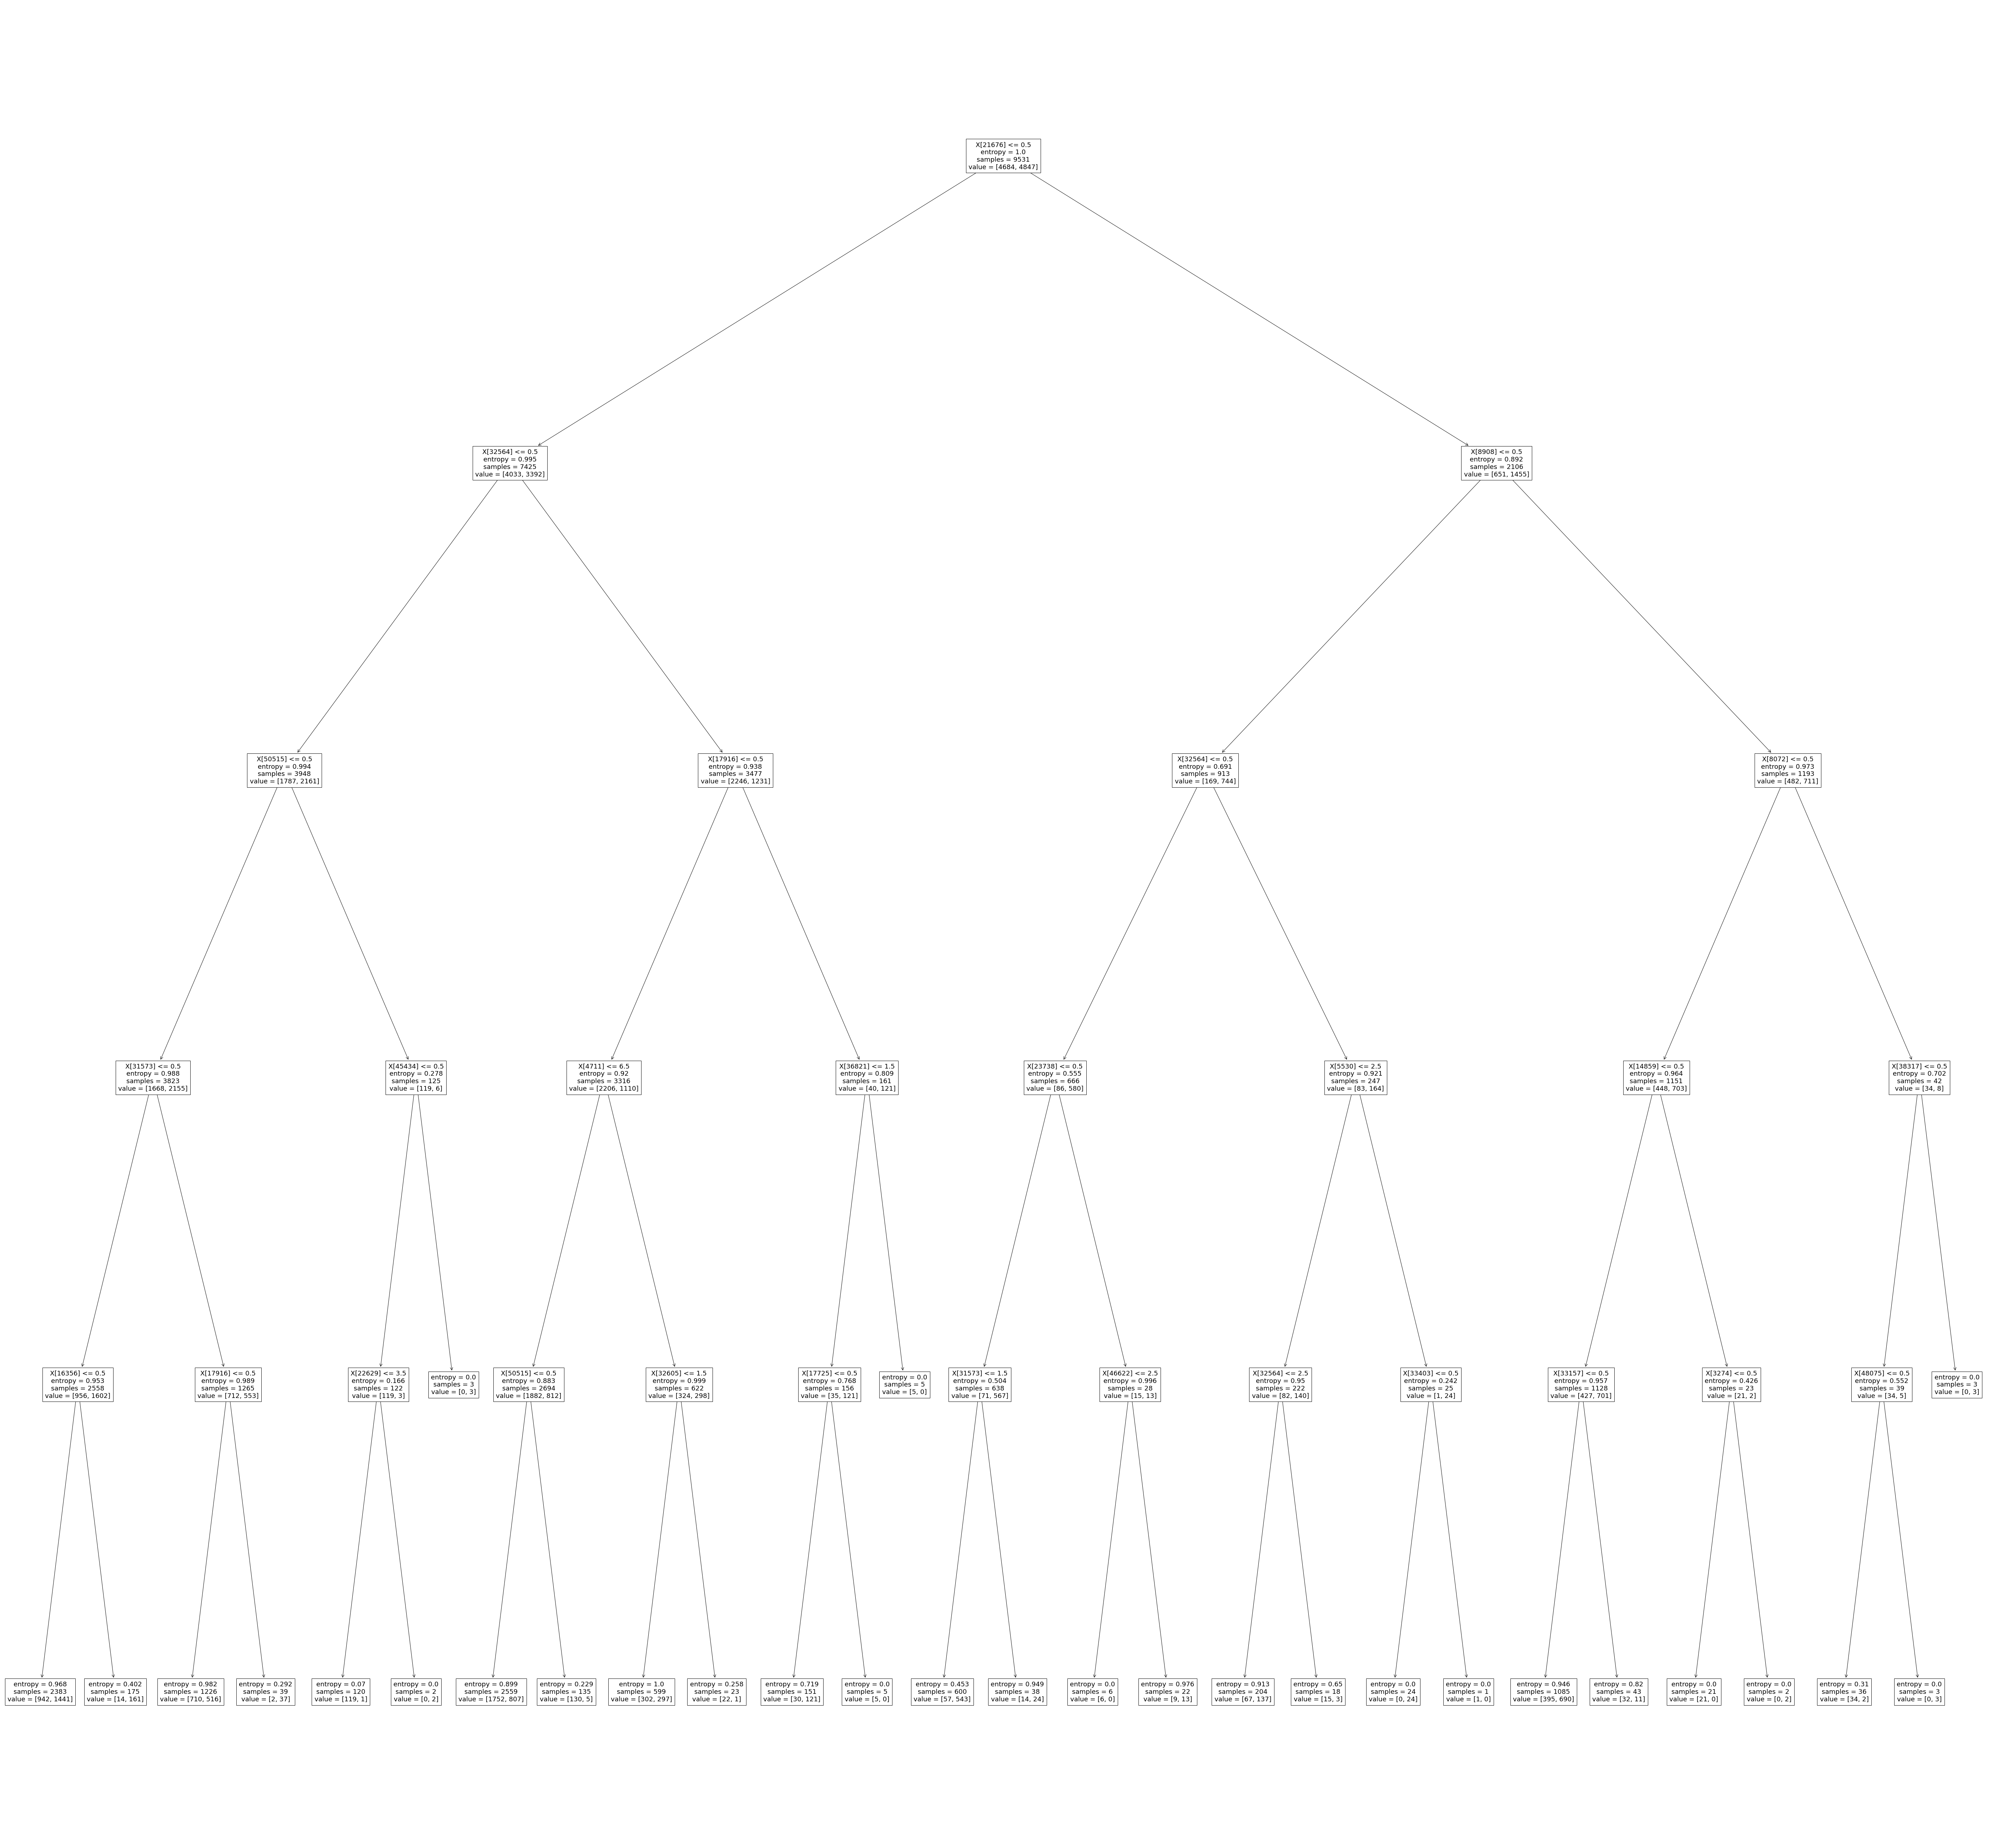

In [51]:
# plotting
plt.figure(figsize = (100, 95))
tree.plot_tree(base_dt)

In [60]:


best_tree = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 1, max_depth = None)
# min_samples_leaf = 3, max_depth = None - 0.6802349979018044
# min_samples_leaf = 5, max_depth = None - 0.6772975241292488
# min_samples_leaf = 1, max_depth = None - 0.6873688627780109
best_tree.fit(train_feat, train_labels)

s = best_tree.score(eval_feat, eval_labels)
# y_pred = best_tree.predict(eval_feat)
# s = accuracy_score(eval_feat, y_pred)

print(s)

0.6873688627780109


In [69]:
## GOOD
parameters = {
    "min_samples_leaf" : [1, 3, 5, 7, 9, 11],
    "max_depth" : [1 , 3, 5, 10, 20, 40]
}

best_tree = sklearn.tree.DecisionTreeClassifier()


grid = GridSearchCV(best_tree, parameters)

grid.fit(train_feat, train_labels)

s = grid.score(eval_feat, eval_labels)


print(s) # accuracy: 0.6898866974402015

0.6898866974402015


              precision    recall  f1-score   support

         neg       0.70      0.67      0.68      1230
         pos       0.66      0.69      0.67      1153

    accuracy                           0.68      2383
   macro avg       0.68      0.68      0.68      2383
weighted avg       0.68      0.68      0.68      2383


Accuracy: 80.90642047838858%


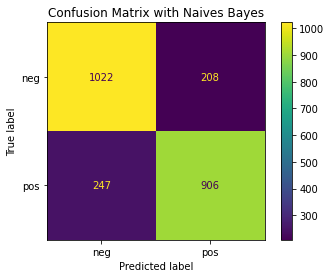

In [70]:
# naive bayes

nb_predictions = base_dt.predict(eval_feat)

report = classification_report(eval_labels, nb_predictions)
print(report)

plot_confusion_matrix(nb, eval_feat, eval_labels)
plt.title('Confusion Matrix with Naives Bayes')
plt.show()

print(f"\nAccuracy: {nb2_accuracy * 100}%")

              precision    recall  f1-score   support

         neg       0.70      0.67      0.68      1230
         pos       0.66      0.69      0.67      1153

    accuracy                           0.68      2383
   macro avg       0.68      0.68      0.68      2383
weighted avg       0.68      0.68      0.68      2383


Accuracy: 67.7717163239614%


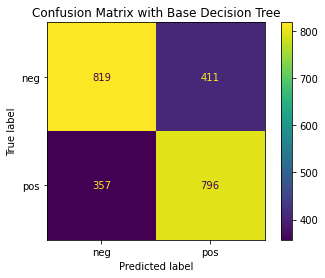

In [71]:
# base decision tree

base_dt_predictions = base_dt.predict(eval_feat)

report = classification_report(eval_labels, base_dt_predictions)
print(report)

plot_confusion_matrix(base_dt, eval_feat, eval_labels)
plt.title('Confusion Matrix with Base Decision Tree')
plt.show()

print(f"\nAccuracy: {base_dt_accuracy * 100}%")

              precision    recall  f1-score   support

         neg       0.70      0.67      0.68      1230
         pos       0.66      0.69      0.67      1153

    accuracy                           0.68      2383
   macro avg       0.68      0.68      0.68      2383
weighted avg       0.68      0.68      0.68      2383


Accuracy: 67.7717163239614%


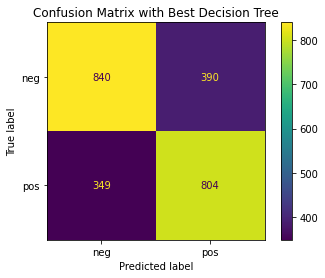

In [72]:
# best decision tree

best_dt_predictions = base_dt.predict(eval_feat)

report = classification_report(eval_labels, best_dt_predictions)
print(report)

plot_confusion_matrix(grid, eval_feat, eval_labels)
plt.title('Confusion Matrix with Best Decision Tree')
plt.show()

print(f"\nAccuracy: {base_dt_accuracy * 100}%")